In [32]:
import numpy as np
import pandas as pd
import sys,os,json
from collections import Counter
import glob
import networkx as nx

sys.path.insert(1, '/home/chacoma/librerias/python')
from plotter_lib import *

db = '/home/chacoma/Lineas/football_4/data/'

arx1 =db+'Sample_Game_1/Sample_Game_1_RawEventsData.csv' 
arx2 =db+'Sample_Game_2/Sample_Game_2_RawEventsData.csv' 


<h1> Animacion para ver de que lado juegan

In [37]:
# archivos con las posiciones para simular
ar1 =db+'Sample_Game_1/X_DS1_raw.json' 
ar2 =db+'Sample_Game_2/X_DS2_raw.json' 
ar3 =db+'Sample_Game_3/X_DS3_raw.json' 


d = json.load(open(ar2,'r'))

T = len(d["2"])

X1= np.array(d["1"])
X2= np.array(d["2"])

print (T, X1.shape, X2.shape )

del d

5646 (5646, 11, 2) (5646, 11, 2)


<IPython.core.display.Javascript object>


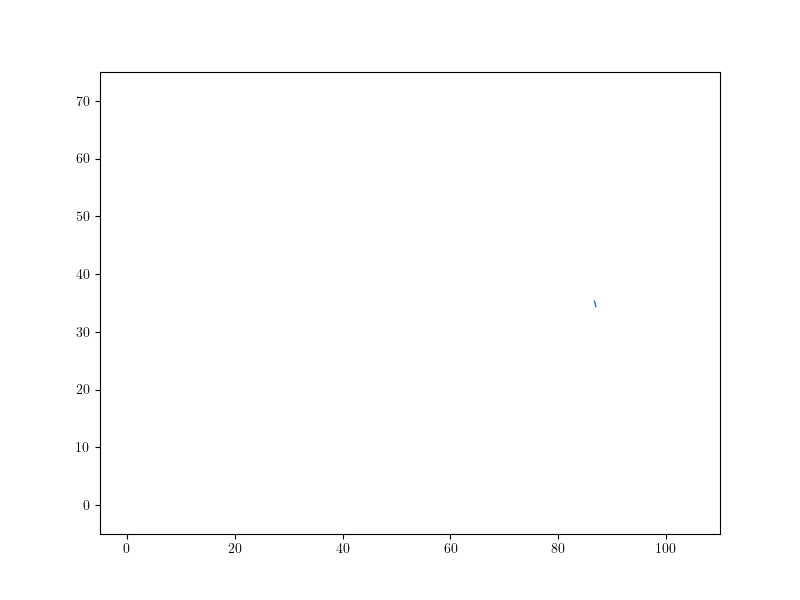

In [38]:
# index (segundo) donde comienza en 2do tiempo en los 3 partidos
# 1er partido 2851, 2do partido 2718, 3er Partido 2803


%matplotlib notebook


fig, ax = plt.subplots( 1,1, figsize=(8,6) )


ps = []

# equipo 1
for i in range(11):
    pi, = ax.plot([], [], linewidth=1, c="C0")
    ps.append(pi)

    
ax.set_xlim(-5,110)
ax.set_ylim(-5,75)



def init():

    for i in range(11):
        ps[i].set_data([], [])

    return ps



def animate(i):
    
    i=i
    
    x1= X1[i]
    dx1 = X1[i+1]-x1
    
    for j in range(11):
        
        if j==0:
            ps[j].set_data( [ x1[j,0],x1[j,0]+dx1[j,0] ], [ x1[j,1],x1[j,1]+dx1[j,1]  ] )
        
       
    
    return ps



anim = FuncAnimation(fig, animate, init_func=init,
                               frames=(500), interval=200, blit=True)

<h1> Jugadas de riesgo

In [4]:
df = pd.read_csv(arx1)

df.head(10)

,#Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,#Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
5,Away,PASS,NaN,1,191,7.64,217,8.68,Player21,Player22,0.40,0.73,0.32,0.98
6,Away,PASS,NaN,1,279,11.16,303,12.12,Player22,Player17,0.39,0.96,0.49,0.98
7,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,Player17,NaN,0.51,0.97,0.27,0.75
8,Home,RECOVERY,INTERCEPTION,1,378,15.12,378,15.12,Player2,NaN,0.27,0.78,NaN,NaN
9,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,Player2,NaN,0.27,0.78,0.59,0.64


In [5]:
Counter(df.loc[ df["#Team"]=="Home"]["Type"]).most_common()

[('PASS', 437),
 ('RECOVERY', 135),
 ('BALL LOST', 129),
 ('CHALLENGE', 118),
 ('SET PIECE', 45),
 ('SHOT', 18),
 ('BALL OUT', 18),
 ('FAULT RECEIVED', 15),
 ('CARD', 2)]

In [6]:
# busco todos los tiempos donde se tiro al arco

Ts1 = np.array(df.loc[ (df["#Team"]=="Home") & (df["Type"]=="SHOT") ]["Start Time [s]"], dtype=int)

Ts2 = np.array(df.loc[ (df["#Team"]=="Away") & (df["Type"]=="SHOT") ]["Start Time [s]"], dtype=int)


print(Ts1)
print(Ts2)

[  91  236  385  730 1064 1247 2147 2151 2306 2511 2700 3081 3600 3960
 3961 4756 4916 5438]
[ 310  778 3010 4344 4990 5361]


<h1> Centroides

In [7]:
df1 = df.loc[ (df["#Team"]=="Home") & (df["Type"]=="PASS") ]
df2 = df.loc[ (df["#Team"]=="Away") & (df["Type"]=="PASS") ]

In [8]:
df2.head(10)

,#Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
5,Away,PASS,NaN,1,191,7.64,217,8.68,Player21,Player22,0.40,0.73,0.32,0.98
6,Away,PASS,NaN,1,279,11.16,303,12.12,Player22,Player17,0.39,0.96,0.49,0.98
19,Away,PASS,NaN,1,763,30.52,784,31.36,Player16,Player19,0.58,0.27,0.51,0.33
20,Away,PASS,NaN,1,784,31.36,804,32.16,Player19,Player20,0.51,0.33,0.57,0.47
21,Away,PASS,NaN,1,834,33.36,881,35.24,Player20,Player22,0.53,0.53,0.44,0.92
22,Away,PASS,NaN,1,976,39.04,1010,40.40,Player22,Player17,0.36,0.96,0.48,0.86


In [9]:
# para el HOME 1
t_seg_tiempo =2851

d={ 1:{"Xcm":[],"Ycm":[], "T":[]},  2:{"Xcm":[],"Ycm":[], "T":[]} }

periodo=1
X,Y=[],[]
L=0
sg=-1


flag=1

for index,row in df1.iterrows():
    
    #X.append( row["Start X"] )
    #Y.append( row["Start Y"] )
    
    X.append( L - (sg*row["Start X"]) )
    Y.append( L - (sg*row["Start Y"]) )
    
    if len(X)>50:    
        X.pop(0)
        Y.pop(0)
        
        if (row["Start Time [s]"]>t_seg_tiempo) and flag:
            periodo=2
            X,Y=[],[]
            L=1
            sg=1
            
            flag=0
            
        else:
            d[periodo]["Xcm"].append(np.mean(X))
            d[periodo]["Ycm"].append(np.mean(Y))
            d[periodo]["T"].append(row["Start Time [s]"])
    

<IPython.core.display.Javascript object>


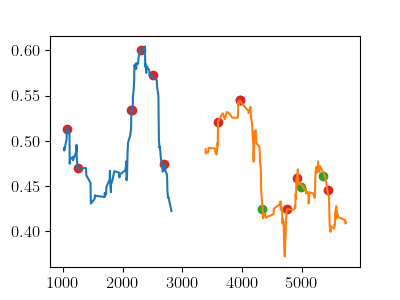

1er tiempo
1064 1063 0.5134
1247 1246 0.4698
2147 2147 0.5338
2151 2147 0.5338
2306 2300 0.6008
2511 2456 0.573
2700 2698 0.4739999999999999
2do tiempo
3600 3599 0.5214
3960 3958 0.5446
3961 3958 0.5446
4756 4751 0.4244
4916 4914 0.4586
5438 5429 0.44559999999999994

2do tiempo
4344 4348 0.42460000000000003
4990 5022 0.4496
5361 5393 0.46159999999999995


In [10]:
plot = Plotter()


plot.ax.plot(d[1]["T"], d[1]["Xcm"])

plot.ax.plot(d[2]["T"], d[2]["Xcm"])


# busco lugar donde fueron los shots 1er tiempo --------------
t1 = np.array(d[1]["T"], dtype =int)
x1 = np.array(d[1]["Xcm"])

x,y = [],[]

print ("1er tiempo" )

for t in Ts1:
        
    if t>=t1[0] and t <=t_seg_tiempo:
    
        index = np.argmin(abs(t1-t))
        
        print (t, t1[index], x1[index])
        
        x.append(t)
        y.append(x1[index])


plot.ax.scatter(x,y, c='C3')


# busco lugar donde fueron los shots 2do tiempo --------------
t1 = np.array(d[2]["T"], dtype =int)
x1 = np.array(d[2]["Xcm"])

x,y = [],[]

print ("2do tiempo" )

for t in Ts1:
        
    if t>=t1[0] and t >=t_seg_tiempo:
    
        index = np.argmin(abs(t1-t))
        
        print (t, t1[index], x1[index])
        
        x.append(t)
        y.append(x1[index])


plot.ax.scatter(x,y, c='C3')



# busco lugar donde fueron los shots del OTRO EQUIPO  --------------
t1 = np.array(d[2]["T"], dtype =int)
x1 = np.array(d[2]["Xcm"])

x,y = [],[]
       
print ("\n2do tiempo" )
       
for t in Ts2:
        
    if t>=t1[0] and t >=t_seg_tiempo:
    
        index = np.argmin(abs(t1-t))
        
        print (t, t1[index], x1[index])
        
        x.append(t)
        y.append(x1[index])

        
plot.ax.scatter(x,y, c='C2')



plt.show()


In [11]:
'''
al parecer entre los tiempos 2147 y 2511, el equipo anduvo bien
adelantado en la cancha (+0.5) y con tiros al arco
--> me interesan las redes de pases de esos 6 minutos 
para caracterizar bajo que extructura de red el equipo juega bien


Por otro lado en el segundo tiempo estuvo xcm<0.5 y recibio
varios shots, indicación de que jugo mal
Esas redes me interesa caracterizar su estructura para
ver si las diferencias estructurales entre buenos y malos 
momentos son significativas
'''


'\nal parecer entre los tiempos 2147 y 2511, el equipo anduvo bien\nadelantado en la cancha (+0.5) y con tiros al arco\n--> me interesan las redes de pases de esos 6 minutos \npara caracterizar bajo que extructura de red el equipo juega bien\n\n\nPor otro lado en el segundo tiempo estuvo xcm<0.5 y recibio\nvarios shots, indicación de que jugo mal\nEsas redes me interesa caracterizar su estructura para\nver si las diferencias estructurales entre buenos y malos \nmomentos son significativas\n'

In [12]:
# busco redes

t_ok = [1064,2151, 2306, 2456, 3600, 3960]

t_no = [4344,4990,5361]
    


In [13]:

get_t = lambda s: int(s.split(".")[0].split("/")[-1])

db = "/home/chacoma/Lineas/football_4/data/passing_network/1/"

arxs = glob.glob(db+"*")

# tiempos donde tengo la red
tiempos = np.array(list(map(get_t, arxs)), dtype=int)

C=[]
Ec=[]

for t in t_ok:
    
    index = np.argmin(abs(tiempos-t))
    
    print(tiempos[index], t)
    
    arx = db+"%d.json"%tiempos[index]
    
    # tomo la red
    d = json.load( open(arx,'r') )
    
    # armo un graph no dirigido---------------
    red={}
    seen=set()
    
    for players, w in d.items():
        n1, n2 = players.split('_')
        

        if (n1,n2) not in seen:

            if (n2,n1) not in seen:

                seen.add((n1,n2))

                red[(n1,n2)]=w

            else:
                red[(n2,n1)]+=w

        else:
            red[(n1,n2)]+=w
    # ------------------------------------------
    
    
    edgelist= [ "%s %s {'weight':%d}" % (nodos[0],nodos[1],w) for nodos,w in red.items() ]
    G = nx.parse_edgelist(edgelist, nodetype = str)
    
    # clustering
    c= nx.clustering(G, weight="weight")
    
    
    
    # centralidad 
    ecs = nx.eigenvector_centrality(G, weight="weight")
    
    print (ecs)
   
    C.append(c)
    Ec.append(ecs)
    
   
    
    
    

1063 1064
{'Player6': 0.4662618655731943, 'Player10': 0.48697348064740076, 'Player8': 0.3516650555020622, 'Player9': 0.23861482731535813, 'Player1': 0.29816530651214107, 'Player2': 0.17809809567532017, 'Player3': 0.2945002581336787, 'Player4': 0.3501288729771721, 'Player5': 0.15412338588704003, 'Player7': 0.08872626452111851, 'Player11': 0.05729638091078677}
2147 2151
{'Player6': 0.30708036111493164, 'Player10': 0.34914426139762406, 'Player4': 0.20026824346735267, 'Player9': 0.21633797317752618, 'Player3': 0.08138678279261326, 'Player1': 0.08088411966479085, 'Player2': 0.2556850251515082, 'Player7': 0.5785670033577794, 'Player11': 0.02257604136897496, 'Player8': 0.1912510681652736, 'Player12': 0.4965109678183469}
2300 2306
{'Player2': 0.21559366952982828, 'Player9': 0.09061281759908839, 'Player7': 0.46069685014911566, 'Player10': 0.3598915294585431, 'Player3': 0.12087258341043912, 'Player8': 0.3773072946935408, 'Player12': 0.5073274911956195, 'Player6': 0.3625663591711948, 'Player4': 0

In [14]:
# tomo lista ordenada con players

players=[]
for i in range(len(C)):

    players +=list(C[i].keys())
    
players = sorted(list(set(players)),  key=lambda a:int(a.split("r")[-1]) )

players

['Player1',
 'Player2',
 'Player3',
 'Player4',
 'Player5',
 'Player6',
 'Player7',
 'Player8',
 'Player9',
 'Player10',
 'Player11',
 'Player12']

In [15]:
D = Ec

data1={}

for j,player in enumerate(players):
    
    data1[player]=[]
    
    for i in range(len(D)):

        try:
            data1[player].append(D[i][player])
        
        except:
            None

            
for player in data1.keys():
    
    mu = np.mean(data1[player])
    sd = np.std(data1[player])
    n = len(data1[player])
    
    # intervalo de confianza
    ci = [ mu-(1.96*sd/np.sqrt(n)), mu+(1.96*sd/np.sqrt(n))]
    
    data1[player] = ci
    

print (data1)

{'Player1': [0.038956532457323806, 0.34009289371960816], 'Player2': [0.16644581338612197, 0.3416143112877349], 'Player3': [0.12010754612433691, 0.23415944516371132], 'Player4': [0.1285085447117543, 0.3128548728792414], 'Player5': [0.13607318498372917, 0.33426830020630866], 'Player6': [0.3056780164941702, 0.41068294681223444], 'Player7': [0.25450219655510276, 0.5527148662419881], 'Player8': [0.16528793727452284, 0.40156416169272724], 'Player9': [0.04383328736172659, 0.2001225908168828], 'Player10': [0.35553893189706537, 0.43544142920258516], 'Player11': [0.012261501375264501, 0.04353198643454403], 'Player12': [0.31361170937539795, 0.4859111224854865]}


<IPython.core.display.Javascript object>


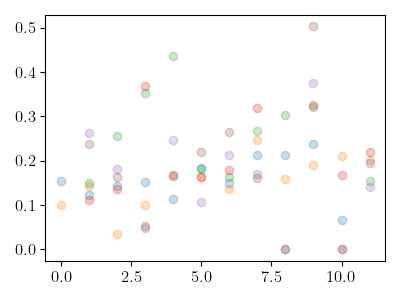

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.15908520073429291 0.04760951455027453
0.15301093624501294 0.056873279063513395
0.25831422543367993 0.09187158272071995
0.21595235880691308 0.08499964255509605
0.15880268759968053 0.11081815442239311
0.17824380033745169 0.1344211578474118


In [16]:
D = C

x = np.arange( 0, len(players), 1)


plot = Plotter()


for i in range(len(D)):
    
    y=[]
    
    for j,player in enumerate(players):
        
        try:
            c = D[i][player]
        except:
            c=np.nan
        
        y.append(c)
    
    print (np.nanmean(y),np.nanstd(y))
    
    plot.ax.scatter(x, y, c='C%d'%i, alpha=0.25)
    
    
    
plot.show()


<h1> Red en tiempos donde recibe shots

In [17]:

get_t = lambda s: int(s.split(".")[0].split("/")[-1])

db = "/home/chacoma/Lineas/football_4/data/passing_network/1/"

arxs = glob.glob(db+"*")

# tiempos donde tengo la red
tiempos = np.array(list(map(get_t, arxs)), dtype=int)

C=[]
Ec=[]

for t in t_no:
    
    index = np.argmin(abs(tiempos-t))
    
    print(tiempos[index], t)
    
    arx = db+"%d.json"%tiempos[index]
    
    # tomo la red
    d = json.load( open(arx,'r') )
    
    # armo un graph no dirigido---------------
    red={}
    seen=set()
    
    for players, w in d.items():
        n1, n2 = players.split('_')
        

        if (n1,n2) not in seen:

            if (n2,n1) not in seen:

                seen.add((n1,n2))

                red[(n1,n2)]=w

            else:
                red[(n2,n1)]+=w

        else:
            red[(n1,n2)]+=w
    # ------------------------------------------
    
    
    edgelist= [ "%s %s {'weight':%d}" % (nodos[0],nodos[1],w) for nodos,w in red.items() ]
    G = nx.parse_edgelist(edgelist, nodetype = str)
    
    # clustering
    c= nx.clustering(G, weight="weight")
    
    
    
    # centralidad 
    ecs = nx.eigenvector_centrality(G, weight="weight")
    
    print (ecs)
   
    C.append(c)
    Ec.append(ecs)

4348 4344
{'Player12': 0.3299283444530241, 'Player6': 0.3956186691261955, 'Player4': 0.30566362685985315, 'Player8': 0.2996168570448589, 'Player10': 0.2210253806203864, 'Player5': 0.2783167283226565, 'Player7': 0.2892949970251821, 'Player2': 0.43286054857433603, 'Player3': 0.3466506197758588, 'Player11': 0.1745140685400479, 'Player9': 0.058639236752099165}
5022 4990
{'Player4': 0.5515103381330464, 'Player8': 0.383633970654545, 'Player5': 0.2220263179962633, 'Player7': 0.05820137265299758, 'Player10': 0.018319080807054078, 'Player2': 0.2416851760915059, 'Player3': 0.3115076994047297, 'Player9': 0.15257617595423748, 'Player12': 0.5395966990325809, 'Player13': 0.1326320449435243, 'Player11': 0.0708207294822295, 'Player14': 0.05606207124368759}
5393 5361
{'Player4': 0.4593734003493483, 'Player8': 0.3822441509036322, 'Player7': 0.2752713733785399, 'Player2': 0.27573335788760217, 'Player3': 0.3221428677711736, 'Player12': 0.44764254957908894, 'Player9': 0.17385308541783334, 'Player13': 0.180

In [18]:
# tomo lista ordenada con players

players=[]
for i in range(len(C)):

    players +=list(C[i].keys())
    
players = sorted(list(set(players)),  key=lambda a:int(a.split("r")[-1]) )

players

['Player2',
 'Player3',
 'Player4',
 'Player5',
 'Player6',
 'Player7',
 'Player8',
 'Player9',
 'Player10',
 'Player11',
 'Player12',
 'Player13',
 'Player14']

<IPython.core.display.Javascript object>


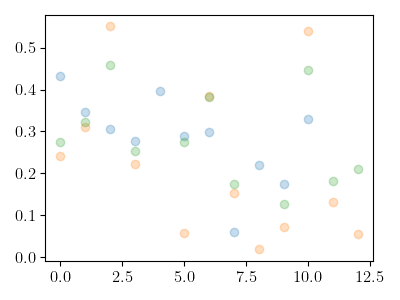

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.2847390070085907 0.09916041950724394
0.22821430636636678 0.17678111806143612
0.28234374084960434 0.10578800930229469


In [19]:
D = Ec

x = np.arange( 0, len(players), 1)


plot = Plotter()


for i in range(len(D)):
    
    y=[]
    
    for j,player in enumerate(players):
        
        try:
            c = D[i][player]
        except:
            c=np.nan
        
        y.append(c)
    
    print (np.nanmean(y),np.nanstd(y))
    
    plot.ax.scatter(x, y, c='C%d'%i, alpha=0.25)
    
    
    
plot.show()

In [20]:
D = Ec

data2={}

for j,player in enumerate(players):
    
    data2[player]=[]
    
    for i in range(len(D)):

        try:
            data2[player].append(D[i][player])
        
        except:
            None

            
for player in data2.keys():
    
    mu = np.mean(data2[player])
    sd = np.std(data2[player])
    n = len(data2[player])
    
    # intervalo de confianza
    ci = [ mu-(1.96*sd/np.sqrt(n)), mu+(1.96*sd/np.sqrt(n))]
    
    data2[player] = ci
    

print (data2)

{'Player2': [0.22253744781255624, 0.4109819405564066], 'Player3': [0.31011555539545543, 0.3434185692390527], 'Player4': [0.3240925180255023, 0.5536057255359963], 'Player5': [0.2252232836717966, 0.2773559414229902], 'Player6': [0.3956186691261955, 0.3956186691261955], 'Player7': [0.08787861746580161, 0.32729987790534476], 'Player8': [0.3107125899703511, 0.3996173957650063], 'Player9': [0.07171164314182762, 0.18500068894095237], 'Player10': [-0.02079606848977561, 0.2601405299172161], 'Player11': [0.07569972158211313, 0.17155682717923185], 'Player12': [0.34195064683811627, 0.5361610818716798], 'Player13': [0.12333695697850892, 0.19009703438403808], 'Player14': [0.026426458716011875, 0.23927821372408123]}


<h1> Comparacion entre las centralidades de los dos casos

In [21]:
data1

{'Player1': [0.038956532457323806, 0.34009289371960816],
 'Player2': [0.16644581338612197, 0.3416143112877349],
 'Player3': [0.12010754612433691, 0.23415944516371132],
 'Player4': [0.1285085447117543, 0.3128548728792414],
 'Player5': [0.13607318498372917, 0.33426830020630866],
 'Player6': [0.3056780164941702, 0.41068294681223444],
 'Player7': [0.25450219655510276, 0.5527148662419881],
 'Player8': [0.16528793727452284, 0.40156416169272724],
 'Player9': [0.04383328736172659, 0.2001225908168828],
 'Player10': [0.35553893189706537, 0.43544142920258516],
 'Player11': [0.012261501375264501, 0.04353198643454403],
 'Player12': [0.31361170937539795, 0.4859111224854865]}

In [22]:
data2

{'Player2': [0.22253744781255624, 0.4109819405564066],
 'Player3': [0.31011555539545543, 0.3434185692390527],
 'Player4': [0.3240925180255023, 0.5536057255359963],
 'Player5': [0.2252232836717966, 0.2773559414229902],
 'Player6': [0.3956186691261955, 0.3956186691261955],
 'Player7': [0.08787861746580161, 0.32729987790534476],
 'Player8': [0.3107125899703511, 0.3996173957650063],
 'Player9': [0.07171164314182762, 0.18500068894095237],
 'Player10': [-0.02079606848977561, 0.2601405299172161],
 'Player11': [0.07569972158211313, 0.17155682717923185],
 'Player12': [0.34195064683811627, 0.5361610818716798],
 'Player13': [0.12333695697850892, 0.19009703438403808],
 'Player14': [0.026426458716011875, 0.23927821372408123]}

In [23]:
s1 = set(list(data1.keys()))
s2 = set(list(data2.keys()))

players = sorted(list(s1.intersection(s2)), key= lambda a:int(a.split('r')[-1])  )

players

['Player2',
 'Player3',
 'Player4',
 'Player5',
 'Player6',
 'Player7',
 'Player8',
 'Player9',
 'Player10',
 'Player11',
 'Player12']

<IPython.core.display.Javascript object>


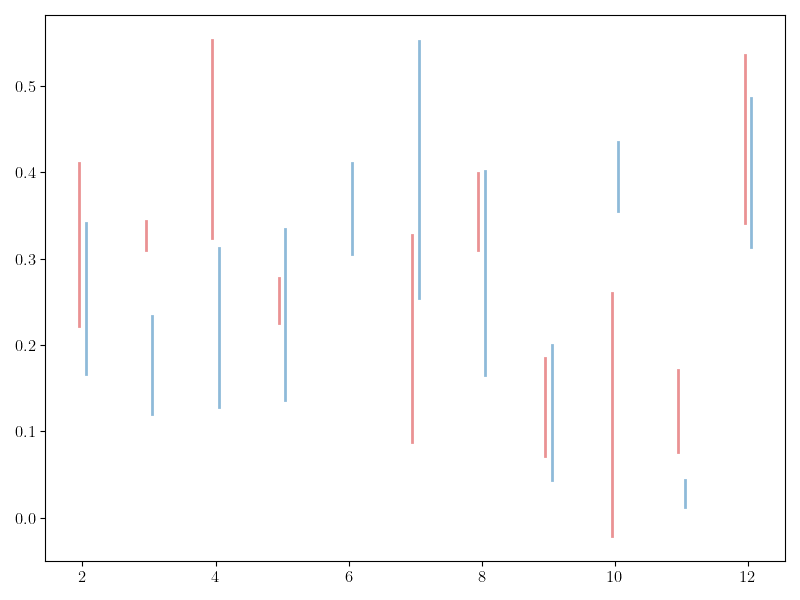

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [24]:
plot= Plotter(W=8,H=6)

for player in players:
    
    x1 = int(player.split('r')[-1])+0.05
    x2 = int(player.split('r')[-1])-0.05
    
    plot.ax.plot( [x1,x1], [ data1[player][0], data1[player][1] ], alpha=0.5, linewidth=2, c='C0')
    
    plot.ax.plot( [x2,x2], [ data2[player][0], data2[player][1] ], alpha=0.5, linewidth=2, c='C3')

    
    
plot.show(loc=3)